In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import sys

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#keras
import keras
import tensorflow as tf
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K

#skopt
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args



def feature_dataframe_gen_train(feature_dir):
    feature_dataframe = []
    for sess in range(1,5) :
        feature_df = pd.read_csv('{}audio_features_{}.csv'.format(feature_dir,sess))
        feature_df = feature_df.sample(frac=1,random_state = 50).reset_index(drop = True)
        feature_dataframe.append(feature_df)
    feature_dataframe = (pd.concat(feature_dataframe)).fillna(0)
    feature_dataframe = feature_dataframe.replace('exc','hap')
    #feature_dataframe = feature_dataframe.drop(feature_dataframe[feature_dataframe.emotions.isin(["sur", "fea"])].index)
    return feature_dataframe

def feature_dataframe_codec_train(feature_dir):
    feature_dataframe = []
    for sess in range(1,5) :
        feature_df = pd.read_csv('{}audio_features_{}_{}.csv'.format(feature_dir,bitrate,sess))
        feature_df = feature_df.sample(frac=1,random_state = 50).reset_index(drop = True)
        feature_dataframe.append(feature_df)
    feature_dataframe = (pd.concat(feature_dataframe)).fillna(0)
    feature_dataframe = feature_dataframe.replace('exc','hap')
    #feature_dataframe = feature_dataframe.drop(feature_dataframe[feature_dataframe.emotions.isin(["sur", "fea"])].index)
    return feature_dataframe

def feature_dataframe_gen_test(feature_dir):
    feature_dataframe = []
    for sess in [5] :
        feature_df = pd.read_csv('{}audio_features_{}.csv'.format(feature_dir,sess))
        feature_df = feature_df.sample(frac=1,random_state = 50).reset_index(drop = True)
        feature_dataframe.append(feature_df)
    feature_dataframe = (pd.concat(feature_dataframe)).fillna(0)
    feature_dataframe = feature_dataframe.replace('exc','hap')
    #feature_dataframe = feature_dataframe.drop(feature_dataframe[feature_dataframe.emotions.isin(["sur", "fea"])].index)
    return feature_dataframe

# This is a function to log traning progress so that can be viewed by TnesorBoard.
def log_dir_name(learning_rate, num_dense_layers,
                activation, filters, dropout, momentum):
    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"
    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate, num_dense_layers,
                      activation, filters, dropout, momentum)

    return log_dir


dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',name='learning_rate')
dim_filters = Integer(low = 32, high = 512, name = 'filters')
#dim_kernel_size = Integer(low = 4, high = 8, name= 'kernel_size')
dim_dropout = Real(low = 0.1, high = 0.6, name = 'dropout')
dim_momentum = Real(low = 0.0, high = 0.99, name = 'momentum')
dim_activation = Categorical(categories=['relu', 'sigmoid'],name='activation')
    
    
dim_num_dense_layers = Integer(low=1, high=4, name='num_dense_layers')

    
    
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_activation,
              dim_filters,
              dim_dropout,
              dim_momentum]
    
default_parameters = [0.0001,2,'relu',256,0.5,0.0]

def create_model(learning_rate, num_dense_layers,
                 activation, filters, dropout, momentum):
    
    model = Sequential()
    model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
    model.add(Activation(activation = activation))
    model.add(Conv1D(filters = filters, kernel_size = 8,padding = 'same'))
    model.add(BatchNormalization()) 
    model.add(Activation(activation = activation))
    model.add(Dropout(rate=dropout))
    model.add(MaxPooling1D(pool_size=(8)))
    for i in range(num_dense_layers):
        name = 'layer2_Conv1D_{0}'.format(i+1)
        model.add(Conv1D(filters = filters,kernel_size = 8 ,padding = 'same', name = name))
        model.add(Activation(activation = activation))
    model.add(BatchNormalization())
    model.add(Activation(activation = activation))
    model.add(Dropout(rate=dropout))
    model.add(MaxPooling1D(pool_size=(8)))
    for i in range(num_dense_layers):
        name = 'layer3_Conv1D_{0}'.format(i+1)
        model.add(Conv1D(filters = filters, kernel_size = 8,padding = 'same', name = name))
        model.add(Activation(activation = activation))
    model.add(Flatten())
    model.add(Dense(4, activation="softmax"))
    opt = keras.optimizers.SGD(learning_rate = learning_rate,momentum = momentum,nesterov=False,decay = 0.0)
    model.compile(optimizer = opt,
                 loss = keras.losses.CategoricalCrossentropy(),
                 metrics = [tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'accuracy'])
    
    return model


model_name = 'Emotion_recognition_iemocap.h5'
best_accuracy = 0.0

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            activation, filters, dropout, momentum):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('activation:',activation)
    print('filters:' ,filters)
    print('dropout:' ,dropout)
    print('momentum:' ,momentum)
    print()
    model = create_model(learning_rate = learning_rate,
                         num_dense_layers = num_dense_layers,
                         activation = activation, 
                         filters = filters, 
                         dropout = dropout, 
                         momentum = momentum)
    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           activation, filters, dropout, momentum)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history=model.fit(X_train, y_train, 
                      batch_size=16, 
                      epochs=60, 
                      validation_data=(X_test, y_test),
                      callbacks=[callback_log])
    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy
    
    save_dir = os.path.join(os.getcwd(),'saved_models')
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    model_path = os.path.join(save_dir,model_name)
    
    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(model_path)
        model_json = model.to_json()
        with open("model_json.json", "w") as file:
            file.write(model_json)
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

if __name__ == '__main__':
    #CodecAugment - 8,16,32,48,64,128 kbps
    ori_feature_dataframe_train = feature_dataframe_gen_train(feature_dir = '../input/iemocap-audio-features/')
    ori_feature_dataframe_train['fold'] = -1
    #codec_feature_dataframe_train = feature_dataframe_codec_train(feature_dir = '../input/iemocap-compressed/')
    #codec_feature_dataframe_train['fold'] = -1
    ori_feature_dataframe_test = feature_dataframe_gen_test(feature_dir = '../input/iemocap-audio-features/')
    ori_feature_dataframe_test['fold'] = 1
    result = (pd.concat([ori_feature_dataframe_train,ori_feature_dataframe_test], ignore_index=True, sort=False)).fillna(0.0)
    result = result.loc[:, (result==0.0).mean() < .9]
    training_data = result[result['fold'] == -1]
    testing_data = result[result['fold'] == 1]
    X_train_data = training_data.drop(['emotions', 'fold'],axis=1)
    X_test_data = testing_data.drop(['emotions', 'fold'],axis=1)
    y_train_data = training_data.emotions
    y_test_data = testing_data.emotions
    scaler = StandardScaler()
    std_scale = scaler.fit(X_train_data)
    X_train = std_scale.transform(X_train_data)
    X_test  = std_scale.transform(X_test_data)
    y_train_ = np.array(y_train_data)
    y_test_ = np.array(y_test_data)
    lb = LabelEncoder()
    y_train = np_utils.to_categorical(lb.fit_transform(y_train_))
    y_test = np_utils.to_categorical(lb.fit_transform(y_test_))
    X_train = np.expand_dims(X_train, axis = 2)
    X_test = np.expand_dims(X_test, axis = 2)
    search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15,
                            x0=default_parameters)   

learning rate: 1.0e-04
num_dense_layers: 2
activation: relu
filters: 256
dropout: 0.5
momentum: 0.0

Epoch 1/3
269/269 [==============================] - 13s 49ms/step - loss: 1.5025 - recall: 0.0662 - precision: 0.4017 - accuracy: 0.3494 - val_loss: 1.3799 - val_recall: 8.0580e-04 - val_precision: 1.0000 - val_accuracy: 0.3852
Epoch 2/3
269/269 [==============================] - 12s 46ms/step - loss: 1.3651 - recall: 0.0795 - precision: 0.4783 - accuracy: 0.3932 - val_loss: 1.3715 - val_recall: 0.0016 - val_precision: 0.1818 - val_accuracy: 0.4311
Epoch 3/3
269/269 [==============================] - 12s 46ms/step - loss: 1.3043 - recall: 0.0881 - precision: 0.5060 - accuracy: 0.4049 - val_loss: 1.3442 - val_recall: 0.0121 - val_precision: 0.7895 - val_accuracy: 0.4174

Accuracy: 41.74%

learning rate: 2.7e-05
num_dense_layers: 4
activation: relu
filters: 209
dropout: 0.14713305788376835
momentum: 0.3985267964348051

Epoch 1/3
269/269 [==============================] - 14s 52ms/step - 

269/269 [==============================] - 7s 26ms/step - loss: 1.3974 - recall: 0.0322 - precision: 0.4299 - accuracy: 0.2832 - val_loss: 1.3723 - val_recall: 0.0048 - val_precision: 0.6000 - val_accuracy: 0.3247

Accuracy: 32.47%

learning rate: 5.3e-04
num_dense_layers: 1
activation: sigmoid
filters: 273
dropout: 0.14626150219046288
momentum: 0.4864881865928891

Epoch 1/3
269/269 [==============================] - 13s 50ms/step - loss: 1.4061 - recall: 0.0035 - precision: 0.2941 - accuracy: 0.2928 - val_loss: 1.4244 - val_recall: 0.3562 - val_precision: 0.3562 - val_accuracy: 0.3562
Epoch 2/3
269/269 [==============================] - 13s 49ms/step - loss: 1.3929 - recall: 0.0124 - precision: 0.2880 - accuracy: 0.3016 - val_loss: 1.3462 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.3143
Epoch 3/3
269/269 [==============================] - 13s 48ms/step - loss: 1.3859 - recall: 0.0119 - precision: 0.3592 - accuracy: 0.3054 - val_loss: 1.5676 - val_recall: 0.0

In [2]:
# loading json and model architecture 
json_file = open('./model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./saved_models/Emotion_recognition_iemocap.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

preds = loaded_model.predict(X_test, batch_size=16, verbose=1)

preds=preds.argmax(axis=1)

print(preds)

Loaded model from disk
recall: 1.45%
78/78 [==============================] - 1s 19ms/step
[0 2 2 ... 2 2 3]


In [3]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)

# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
print(finaldf.groupby('predictedvalues').count())

                 actualvalues
predictedvalues              
ang                       104
hap                       203
neu                       708
sad                       226


In [4]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.44480257856567285


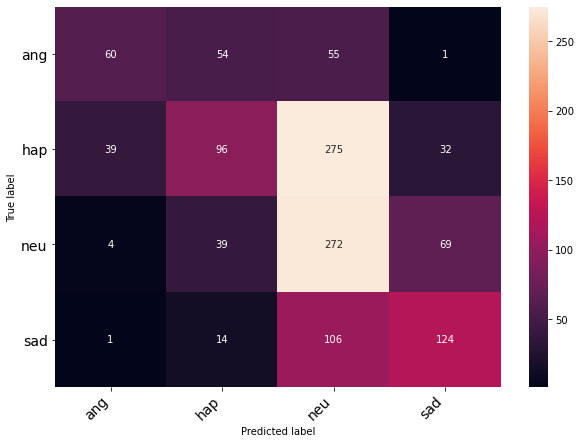

In [5]:
finaldf = pd.read_csv("./Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
plt.show(print_confusion_matrix(c, class_names = classes))

In [6]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

         ang       0.58      0.35      0.44       170
         hap       0.47      0.22      0.30       442
         neu       0.38      0.71      0.50       384
         sad       0.55      0.51      0.53       245

    accuracy                           0.44      1241
   macro avg       0.50      0.45      0.44      1241
weighted avg       0.47      0.44      0.42      1241

